In [1]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [5]:
# Gdown is a Python package that can be used to download large files from Google Drive. Gdown is useful because it can download files that are too large for wget or curl.
import gdown

In [6]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=b2dabcd2-b6e3-406b-b19d-76a892a8a610
To: /kaggle/working/data.zip
100%|██████████| 423M/423M [00:03<00:00, 130MB/s]  


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [7]:
import cv2

def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames-mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(
f"The vocubaly is {char_to_num.get_vocabulary()}"
f"(size = {char_to_num.vocab_size()})"
)

The vocubaly is ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size = 40)


In [10]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [11]:
char_to_num(['n', 'i', 'c', 'k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [12]:
num_to_char([14, 9, 3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [13]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [14]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [15]:
test_path = './data/s1/bbal6n.mpg'

In [16]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [17]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

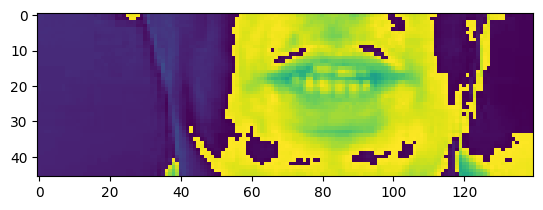

In [18]:
plt.imshow(frames[40])

In [19]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [20]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [21]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

<h1>Create Data Pipeline</h1>

In [22]:
from matplotlib import pyplot as plt

In [23]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

# Added for split
train = data.take(450)
test = data.skip(450)

In [24]:
len(test)

50

In [25]:
frames, alignments = data.as_numpy_iterator().next()

In [26]:
len(frames)

2

In [27]:
sample = data.as_numpy_iterator()

In [28]:
val = sample.next(); val[0]

array([[[[[1.3511412 ],
          [1.3125372 ],
          [0.84928876],
          ...,
          [0.3088323 ],
          [0.3088323 ],
          [0.3088323 ]],

         [[1.119517  ],
          [1.2739332 ],
          [0.81068474],
          ...,
          [0.3088323 ],
          [0.3088323 ],
          [0.3088323 ]],

         [[1.5827655 ],
          [1.5827655 ],
          [1.2739332 ],
          ...,
          [0.3088323 ],
          [0.27022824],
          [0.27022824]],

         ...,

         [[1.158121  ],
          [1.080913  ],
          [1.080913  ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],

         [[1.080913  ],
          [1.080913  ],
          [1.080913  ],
          ...,
          [9.844028  ],
          [9.844028  ],
          [9.844028  ]],

         [[1.080913  ],
          [1.080913  ],
          [1.080913  ],
          ...,
          [9.844028  ],
          [9.844028  ],
          [9.844028  ]]],


        [[[1.3511

In [29]:
# imageio.mimsave('./animation.gif', val[0][0], duration=5)

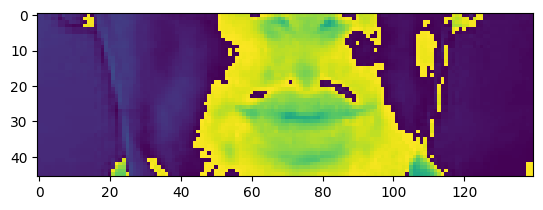

In [30]:
# 0:videos, 0: 1st video of the batch, 0: return the first frame in the video
plt.imshow(val[0][0][35])

In [31]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with t one again'>

<h1>Design the Deep Neural Network</h1>

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [33]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [34]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [36]:
5*17*75

6375

In [37]:
yhat = model.predict(val[0])

1/1 [==============================] - 6s 6s/step


In [38]:
print(yhat)

[[[0.02125181 0.02328033 0.02541278 ... 0.03168147 0.02117103 0.02038066]
  [0.01993481 0.02170013 0.02613031 ... 0.03062868 0.02034465 0.02109766]
  [0.01900579 0.02021157 0.02722384 ... 0.02933253 0.019861   0.02212124]
  ...
  [0.02114508 0.01606804 0.03044825 ... 0.01937515 0.02134323 0.02951392]
  [0.02187986 0.01659197 0.03021686 ... 0.01918258 0.02171438 0.02976126]
  [0.02268832 0.01719542 0.03006335 ... 0.01912247 0.02240218 0.02946015]]

 [[0.02073127 0.0237683  0.02575218 ... 0.02374747 0.01901748 0.02042429]
  [0.01959139 0.02242346 0.02592202 ... 0.02263827 0.01840511 0.02119129]
  [0.01882609 0.02118765 0.02625836 ... 0.02151277 0.01796978 0.0222576 ]
  ...
  [0.02005697 0.0188323  0.02527401 ... 0.01691004 0.02277372 0.03181618]
  [0.02087492 0.01903756 0.02451727 ... 0.0173664  0.02356159 0.03222798]
  [0.02186399 0.01925755 0.02405349 ... 0.01779086 0.02458485 0.03196823]]]


In [39]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0], axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'7777uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu'>

In [40]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'7777uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu'>

In [41]:
model.input_shape

(None, 75, 46, 140, 1)

In [42]:
model.output_shape

(None, 75, 41)

<h1>Setup Training Optiona and Train</h1>

In [43]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [44]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [45]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
        
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original: ', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction: ', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [46]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [47]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint'), monitor='loss', save_weights_only=True)

In [48]:
schedule_callback = LearningRateScheduler(scheduler)

In [49]:
example_callback = ProduceExample(test)

In [50]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
447/450 [============================>.] - ETA: 2s - loss: 84.2754

[mpeg1video @ 0x7dfc980aa3c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7dfc980aa3c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 84.2206

[mpeg1video @ 0x7dfc90212480] ac-tex damaged at 22 17
[mpeg1video @ 0x7dfc90212480] Warning MVs not available
[mpeg1video @ 0x7dfbd00a2bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7dfbd00a2bc0] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original:  lay white sp by z five soon
Prediction:  le e e e e o o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place green by r three again
Prediction:  le e e e e o o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 772s 2s/step - loss: 84.2206 - val_loss: 71.5515 - lr: 1.0000e-04
Epoch 2/100
296/450 [==================>...........] - ETA: 1:51 - loss: 71.4183

[mpeg1video @ 0x7dfb3c00cdc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7dfb3c00cdc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 70.9290

[mpeg1video @ 0x7dfc940d4100] ac-tex damaged at 22 17
[mpeg1video @ 0x7dfc940d4100] Warning MVs not available


1/1 [==============================] - 0s 127ms/step
Original:  lay white with m two please
Prediction:  la e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  bin blue at l eight please
Prediction:  la e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 554s 1s/step - loss: 70.9290 - val_loss: 66.2233 - lr: 1.0000e-04
Epoch 3/100
164/450 [=========>....................] - ETA: 3:26 - loss: 68.0377

[mpeg1video @ 0x7dfb3c0d6e00] ac-tex damaged at 22 17
[mpeg1video @ 0x7dfb3c0d6e00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 66.9268

[mpeg1video @ 0x7dfc90007900] ac-tex damaged at 22 17
[mpeg1video @ 0x7dfc90007900] Warning MVs not available


1/1 [==============================] - 0s 127ms/step
Original:  set green by j three again
Prediction:  la e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  set green at i seven soon
Prediction:  la e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 552s 1s/step - loss: 66.9268 - val_loss: 61.3857 - lr: 1.0000e-04
Epoch 4/100
300/450 [===================>..........] - ETA: 1:49 - loss: 64.6386

[mpeg1video @ 0x7dfbd0070d80] ac-tex damaged at 22 17
[mpeg1video @ 0x7dfbd0070d80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 64.2047

[mpeg1video @ 0x7dfc901f7980] ac-tex damaged at 22 17
[mpeg1video @ 0x7dfc901f7980] Warning MVs not available


1/1 [==============================] - 0s 128ms/step
Original:  lay white in y eight please
Prediction:  la e e t e eon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay green with g three soon
Prediction:  la e e t e eon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 557s 1s/step - loss: 64.2047 - val_loss: 60.7396 - lr: 1.0000e-04
Epoch 5/100
403/450 [=========================>....] - ETA: 33s - loss: 62.0691

[mpeg1video @ 0x7dfbd01c8d80] ac-tex damaged at 22 17
[mpeg1video @ 0x7dfbd01c8d80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 61.9488

UnknownError: Graph execution error:

2 root error(s) found.
  (0) UNKNOWN:  InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} sizes input must be 1-D, not [27,1] [Op:Reshape]
Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 265, in __call__
    return func(device, token, args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 143, in __call__
    outputs = self._call(device, args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 150, in _call
    ret = self._func(*args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_29/1787057329.py", line 6, in load_data
    frames = load_video(video_path)

  File "/tmp/ipykernel_29/2911758936.py", line 8, in load_video
    frame = tf.image.rgb_to_grayscale(frame)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} sizes input must be 1-D, not [27,1] [Op:Reshape]


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
	 [[CTCLoss/Shape_3/_4]]
  (1) UNKNOWN:  InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} sizes input must be 1-D, not [27,1] [Op:Reshape]
Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 265, in __call__
    return func(device, token, args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 143, in __call__
    outputs = self._call(device, args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 150, in _call
    ret = self._func(*args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_29/1787057329.py", line 6, in load_data
    frames = load_video(video_path)

  File "/tmp/ipykernel_29/2911758936.py", line 8, in load_video
    frame = tf.image.rgb_to_grayscale(frame)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} sizes input must be 1-D, not [27,1] [Op:Reshape]


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_1516403]

<h1>Saving the model</h1>

In [ ]:
model.save_weights('../working/weights')

# Create a new model instance
# model = create_model()

# # Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

# # Evaluate the model
# loss, acc = model.evaluate(test_images, test_labels, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
p

<h1>Make a Prediction</h1>

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in senetence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.ctc_decode(yhat, input_length=[75, 75], greedy=True)[0][0].numpy()

In [ ]:
print('~', 'PREDICTIONS')
[tf.strings.reduce_joins([nums_to_char(word) for word in sentence]) for sentence in decoded]

<h1>Test on a video</h1>

In [ ]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]